<a href="https://colab.research.google.com/github/JeffBaksa/capstone3/blob/main/Image_Plots_and_Matrix_Shortened_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import PIL
from datetime import datetime
from functools import partial
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import Model

from skimage import io, color, filters
from skimage.transform import resize, rotate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Image data generator & flow from dir
train_path = '/content/drive/MyDrive/capstone3/disease_data3/train'
test_path = '/content/drive/MyDrive/capstone3/disease_data3/test'
valid_path = '/content/drive/MyDrive/capstone3/disease_data3/valid'
bs = 32

In [4]:
train_batches = ImageDataGenerator(rescale=1/255, horizontal_flip=True, vertical_flip=True, shear_range=0.2, rotation_range=60).flow_from_directory(train_path, target_size=(224, 224), batch_size=bs)
test_batches = ImageDataGenerator(rescale=1/255).flow_from_directory(test_path, target_size=(224, 224), batch_size=bs)
valid_batches = ImageDataGenerator(rescale=1/255).flow_from_directory(valid_path, target_size=(224, 224), batch_size=bs)

Found 8747 images belonging to 10 classes.
Found 1158 images belonging to 10 classes.
Found 1208 images belonging to 10 classes.


## Image Plot

In [96]:
def image_plot_predict(rows, batch, model, cols=bs):  
    """ 
    Plots images with thier predicted class and actual class  
  
    Used after model has been fit to see results of test data
  
    Parameters: 
    rows (int): number of rows for the images displayed
    batch (ImageDataGenerator): test batch of pictures that will be predicted in model
    model : the model training images have been trained on to be used to predict test images
    cols (int) : number of columns displayed ( set to batch size )
    
    
    Returns: 
    plot: Plot of images with their predicted class and their actual class
    """
    types = ['Apple - Apple Scab', 'Apple - Black Rot', 'Apple - Cedar Apple Rust', 'Apple - Healthy', 'Corn - Cercospora Leaf Spot', 'Corn - Common Rust', 'Corn - Northern Leaf Blight', 'Corn - Healthy', 'Grape - Black Rot', 'Grape - Healthy']
    fig, axs = plt.subplots(rows,cols,figsize=(cols * 4,rows * 4))
    for i in range(rows):
        images, labels = next(batch)
        predictions = model.predict(images)
        for j, pic in enumerate(images):
            title = 'Predicted: ' + types[list(predictions[j]).index(predictions[j].max())] + ' ' + '\n' + 'Actual: ' + types[list(labels[j]).index(1)] + '\n' + 'Confidence: ' + str(predictions[j].max().round(2))
            if rows > 1:
                axs[i,j].imshow(pic, extent=[0, 20, 0, 15], aspect=1)
                axs[i,j].set_title(title)
                axs[i,j].axis('off')
                if types[list(predictions[j]).index(predictions[j].max())] != types[list(labels[j]).index(1)]:
                  axs[i,j].set_title(title, color='red')
            else:
                axs[j].imshow(pic, extent=[0, 20, 0, 15], aspect=1)
                axs[j].set_title(title)
                axs[j].axis('off')
                if types[list(predictions[j]).index(predictions[j].max())] != types[list(labels[j]).index(1)]:
                  axs[i,j].set_title(title, color='red')
    plt.tight_layout()
    plt.show()

## Confusion Matrix

In [6]:
def con_fu(rows, test_batches, model):
    """ 
    Collects data for confusion_matrix 
  
    Used in conjunction with sklearn.metrics confusion_matrix function
  
    Parameters: 
    rows (int): number of pictures will be predicted on
    test_batches (ImageDataGenerator) : the pictures that will be predicted
    model : the model training images have been trained on to be used to predict test images
    
    
    
    Returns: 
    actual (list) : list of actual class per image
    preds (list) : list of predicted class per image
    miss_class (list) : list of images that were missclassified
    """
    actual = []
    preds = []
    miss_class = []
    miss_predictions = []
    for i in range(rows):
      images, labels = next(test_batches)
      predictions = model.predict(images)
      for j, h in enumerate(labels):
        act_ = list(h).index(1.)
        pred_ = list(predictions[j]).index(predictions[j].max())
        actual.append(act_)
        preds.append(pred_)
        if act_ != pred_:
          miss_class.append(images[j])
          miss_predictions.append([act_, pred_])
    return actual, preds, miss_class, miss_predictions

## Model

In [7]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [8]:
resn_model = keras.models.Sequential()
resn_model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
resn_model.add(keras.layers.BatchNormalization())
resn_model.add(keras.layers.Activation("relu"))
resn_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resn_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
resn_model.add(keras.layers.GlobalAvgPool2D())
resn_model.add(keras.layers.Flatten())
resn_model.add(keras.layers.Dense(128, activation="relu"))
resn_model.add(keras.layers.Dropout(0.25))
resn_model.add(keras.layers.Dense(10, activation="softmax"))

# Compile model
resn_model.compile(loss='categorical_crossentropy', optimizer=Adam(.001), metrics=['accuracy'])

# Tensorboard Callback
resn_tb_callback = TensorBoard(log_dir = 'logdir', histogram_freq=1)

# Early Stopping
resn_es = EarlyStopping(monitor='loss', patience=20, verbose=1)

# Save checkpoint file name
checkpoint_path = "drive/MyDrive/capstone3/checkpoints/resnet__disease_thurs/cp-{epoch:04d}.ckpt" # all the trained weights
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint
resn_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True,
    save_best_only = True, 
    monitor = 'val_accuracy',
    save_freq = 'epoch')

In [9]:
# Loading in the model from a specific checkpoint (best of day 1)
resn_model.load_weights('drive/MyDrive/capstone3/checkpoints/resnet__disease_thurs/cp-0074.ckpt')
loss, acc = resn_model.evaluate(valid_batches, verbose=1)
print("Restored model, loss: {:5.2f}".format(loss))
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

38/38 [==============================] - 282s 7s/step - loss: 0.0207 - accuracy: 0.9950
Restored model, loss:  0.02
Restored model, accuracy: 99.50%


In [10]:
# ResNet34 Evaluation
resn_model.evaluate(test_batches)

37/37 [==============================] - 268s 7s/step - loss: 0.0476 - accuracy: 0.9870


[0.047649312764406204, 0.9870466589927673]

## Plots

In [67]:
# To Make image plots we need to read in images with a smaller batch size
test_batches2 = ImageDataGenerator(rescale=1/255).flow_from_directory(test_path, target_size=(224, 224), batch_size=4)

Found 1158 images belonging to 10 classes.


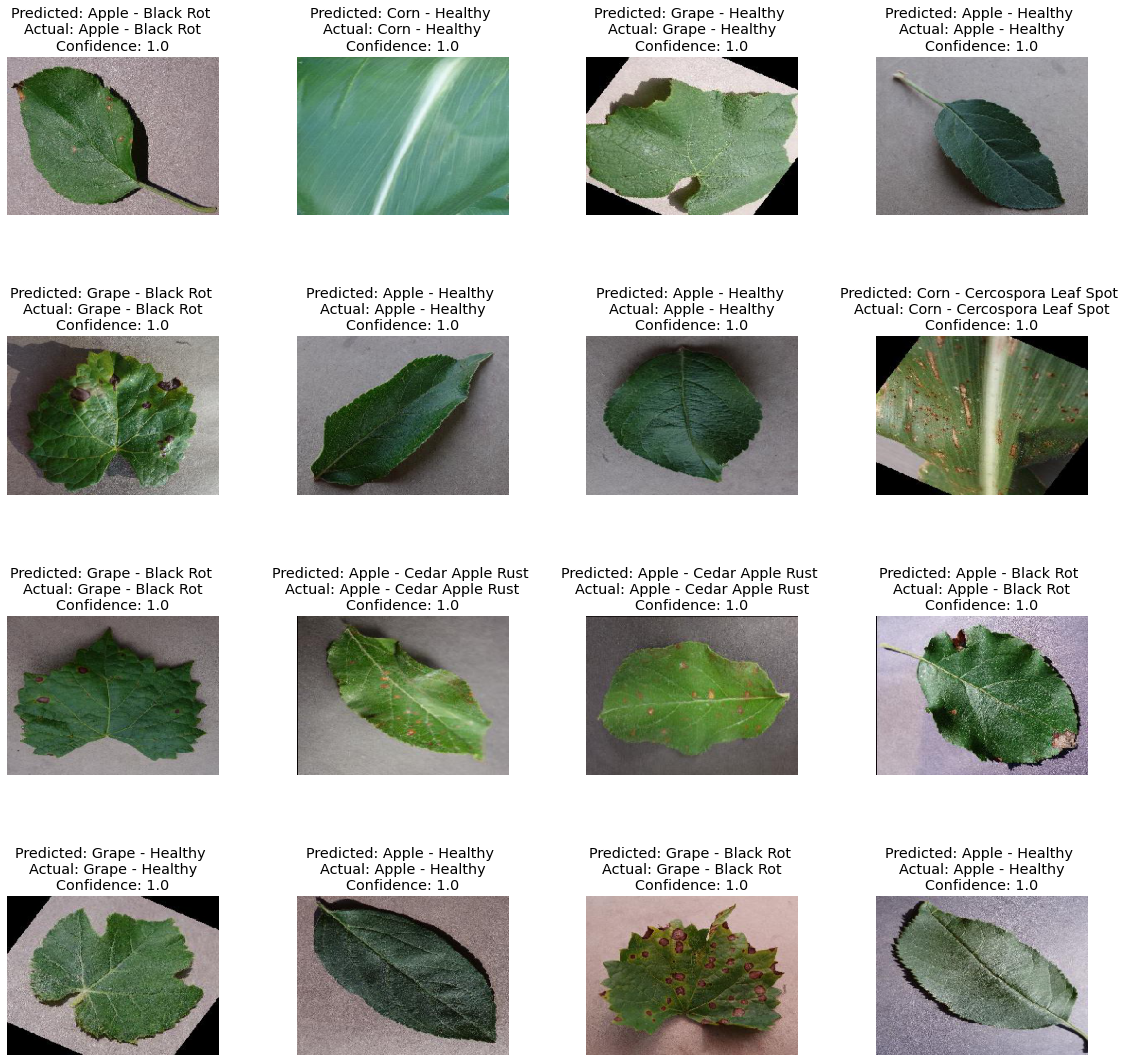

In [98]:
# Use helper function to plot correct/incorrect predictions
image_plot_predict(4, test_batches2, resn_model, cols=4)

In [17]:
# Used w/ confusion matrix
resn_actual, resn_predictions, resn_pics, resn_miss_predictions = con_fu(100, test_batches, resn_model) # can increase the number to however many times you want to run it

In [32]:
resn_accuracy = np.round(accuracy_score(resn_predictions, resn_actual) * 100, 2) # 0.9872
resn_recall = np.round(recall_score(resn_predictions, resn_actual, average='macro') * 100, 2) # 0.9879
resn_precision = np.round(precision_score(resn_predictions, resn_actual, average='macro') * 100, 2) # 0.9864
resn_f1 = np.round(f1_score(resn_predictions, resn_actual, average='macro') * 100, 2) # .9868
print("ResNet34 Model \n-------------")
print(f"Accuracy: {resn_accuracy}%")
print(f"Precision: {resn_precision}%")
print(f"Recall: {resn_recall}%")
print(f"F1 Score: {resn_f1}%")

ResNet34 Model 
-------------
Accuracy: 98.72%
Precision: 98.64%
Recall: 98.8%
F1 Score: 98.68%


98.72

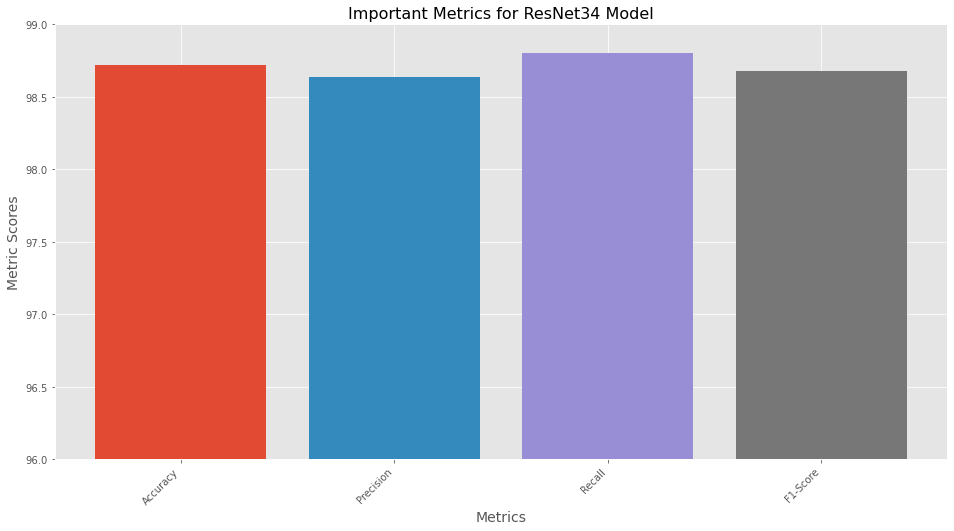

In [59]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [resn_accuracy, resn_precision, resn_recall, resn_f1]

fig, ax = plt.subplots(figsize=(16, 8))
for label, score in zip(labels, scores):
    ax.bar(label, score)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Metric Scores', fontsize=14)
    ax.set_xlabel('Metrics', fontsize=14)
    ax.set_ylim(96, 99)
    ax.set_title('Important Metrics for ResNet34 Model', fontsize=16)
    

Text(0.5, 87.0, 'Predictions')

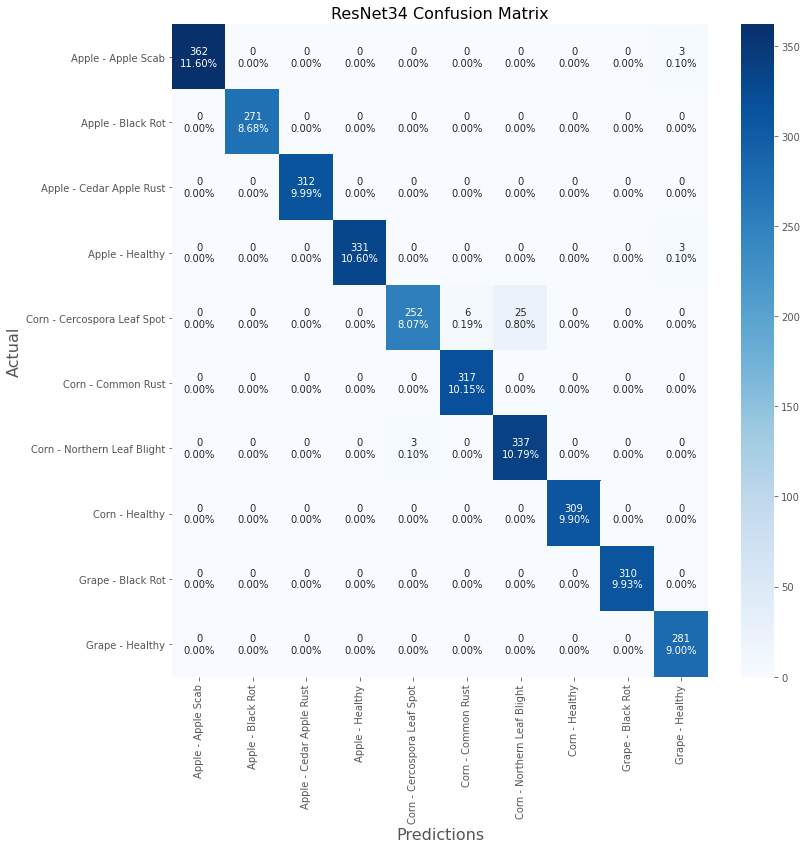

In [116]:
resn_cf = confusion_matrix(resn_actual, resn_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
types = ['Apple - Apple Scab', 'Apple - Black Rot', 'Apple - Cedar Apple Rust', 'Apple - Healthy', 'Corn - Cercospora Leaf Spot', 'Corn - Common Rust', 'Corn - Northern Leaf Blight', 'Corn - Healthy', 'Grape - Black Rot', 'Grape - Healthy']

#group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in resn_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in resn_cf.flatten()/np.sum(resn_cf)]
#group_percentages_1 = ["{0:.2%}".format(value) for value in resn_cf.flatten()[2:]/np.sum(resn_cf[1])]
#group_percentages = np.concatenate([group_percentages_0[:2], group_percentages_1])

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(resn_cf.shape[0], resn_cf.shape[1])

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(resn_cf, xticklabels=types, yticklabels=types, annot=labels, fmt='', cmap='Blues')
ax.set_title('ResNet34 Confusion Matrix', fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predictions', fontsize=16)

AttributeError: ignored